In [92]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Predict the total expected discharges for each DRG Type for the State of New York

### Data Preparation

In [93]:
df = pd.read_csv('../data/raw/Hospital_Inpatient_Discharges__SPARCS_De-Identified___Cost_Transparency__Beginning_2009_20250426.csv')
df.head()

,Year,Facility Id,Facility Name,APR DRG Code,APR Severity of Illness Code,APR DRG Description,APR Severity of Illness Description,APR Medical Surgical Code,APR Medical Surgical Description,Discharges,Mean Charge,Median Charge,Mean Cost,Median Cost
0,2016,4,Albany Memorial Hospital,194,1,Heart Failure,Minor,M,Medical,2,"8,375.41","8,375.41","3,585.05","3,585.05"
1,2016,4,Albany Memorial Hospital,194,2,Heart Failure,Moderate,M,Medical,40,"14,029.82","12,176.95","6,182.67","5,253.15"
2,2016,4,Albany Memorial Hospital,194,3,Heart Failure,Major,M,Medical,70,"23,921.77","20,229.81","11,149.49","9,068.10"
3,2016,4,Albany Memorial Hospital,194,4,Heart Failure,Extreme,M,Medical,12,"51,260.45","35,210.82","26,081.70","15,230.62"
4,2016,4,Albany Memorial Hospital,196,4,Cardiac Arrest,Extreme,M,Medical,1,"25,357.84","25,357.84","7,791.75","7,791.75"


In [94]:
# find the column names and types
print(df.dtypes)
print(df.columns)

# find the number of rows and columns
print(df.shape)

Year                                    int64
Facility Id                             int64
Facility Name                          object
APR DRG Code                            int64
APR Severity of Illness Code            int64
APR DRG Description                    object
APR Severity of Illness Description    object
APR Medical Surgical Code              object
APR Medical Surgical Description       object
Discharges                             object
Mean Charge                            object
Median Charge                          object
Mean Cost                              object
Median Cost                            object
dtype: object
Index(['Year', 'Facility Id', 'Facility Name', 'APR DRG Code',
       'APR Severity of Illness Code', 'APR DRG Description',
       'APR Severity of Illness Description', 'APR Medical Surgical Code',
       'APR Medical Surgical Description', 'Discharges', 'Mean Charge',
       'Median Charge', 'Mean Cost', 'Median Cost'],
      dtype='obje

In [95]:
# Remove commas and convert to float
charge_cost_columns = ['Mean Charge', 'Median Charge', 'Mean Cost', 'Median Cost']
for col in charge_cost_columns:
    df[col] = df[col].str.replace(',', '').astype(float)

# Convert Discharges to integer
df['Discharges'] = df['Discharges'].str.replace(',', '').astype(int)

print(df.dtypes)

Year                                     int64
Facility Id                              int64
Facility Name                           object
APR DRG Code                             int64
APR Severity of Illness Code             int64
APR DRG Description                     object
APR Severity of Illness Description     object
APR Medical Surgical Code               object
APR Medical Surgical Description        object
Discharges                               int32
Mean Charge                            float64
Median Charge                          float64
Mean Cost                              float64
Median Cost                            float64
dtype: object


In [96]:
df.head()

,Year,Facility Id,Facility Name,APR DRG Code,APR Severity of Illness Code,APR DRG Description,APR Severity of Illness Description,APR Medical Surgical Code,APR Medical Surgical Description,Discharges,Mean Charge,Median Charge,Mean Cost,Median Cost
0,2016,4,Albany Memorial Hospital,194,1,Heart Failure,Minor,M,Medical,2,8375.41,8375.41,3585.05,3585.05
1,2016,4,Albany Memorial Hospital,194,2,Heart Failure,Moderate,M,Medical,40,14029.82,12176.95,6182.67,5253.15
2,2016,4,Albany Memorial Hospital,194,3,Heart Failure,Major,M,Medical,70,23921.77,20229.81,11149.49,9068.10
3,2016,4,Albany Memorial Hospital,194,4,Heart Failure,Extreme,M,Medical,12,51260.45,35210.82,26081.70,15230.62
4,2016,4,Albany Memorial Hospital,196,4,Cardiac Arrest,Extreme,M,Medical,1,25357.84,25357.84,7791.75,7791.75


In [97]:
print(df.isnull().sum())

Year                                     0
Facility Id                              0
Facility Name                            0
APR DRG Code                             0
APR Severity of Illness Code             0
APR DRG Description                      0
APR Severity of Illness Description    210
APR Medical Surgical Code              479
APR Medical Surgical Description         0
Discharges                               0
Mean Charge                              0
Median Charge                            0
Mean Cost                                0
Median Cost                              0
dtype: int64


In [98]:
missing_rows = df[df.isnull().any(axis=1)]
missing_rows

,Year,Facility Id,Facility Name,APR DRG Code,APR Severity of Illness Code,APR DRG Description,APR Severity of Illness Description,APR Medical Surgical Code,APR Medical Surgical Description,Discharges,Mean Charge,Median Charge,Mean Cost,Median Cost
1523,2016,1,Albany Medical Center Hospital,956,0,Ungroupable,Not Applicable,NaN,Other,1,31000.32,31000.32,12274.23,12274.23
3546,2016,85,Auburn Community Hospital,955,0,Principal Diagnosis Invalid As Discharge Diagn...,Not Applicable,NaN,Other,1,13675.50,13675.50,4807.53,4807.53
4869,2016,1438,Bellevue Hospital Center,955,0,Principal Diagnosis Invalid As Discharge Diagn...,Not Applicable,NaN,Other,1,2545.00,2545.00,1322.79,1322.79
6362,2016,1178,Bronx-Lebanon Hospital Center - Concourse Divi...,955,0,Principal Diagnosis Invalid As Discharge Diagn...,Not Applicable,NaN,Other,10,7348.20,4676.48,6644.60,3976.82
7271,2016,1286,Brookdale Hospital Medical Center,955,0,Principal Diagnosis Invalid As Discharge Diagn...,Not Applicable,NaN,Other,1,16986.42,16986.42,9718.78,9718.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191076,2021,3067,Millard Fillmore Suburban Hospital,955,0,PRINCIPAL DIAGNOSIS INVALID AS DISCHARGE DIAGN...,Not Applicable,NaN,Other,4,5647.67,4723.04,2922.06,1839.80
1191841,2021,3376,Cohen Children's Medical Center,955,0,PRINCIPAL DIAGNOSIS INVALID AS DISCHARGE DIAGN...,Not Applicable,NaN,Other,1,60927.00,60927.00,8077.91,8077.91
1191842,2021,3376,Cohen Children's Medical Center,956,0,UNGROUPABLE,Not Applicable,NaN,Other,8,16277.62,14935.96,2908.46,2524.23
1192563,2021,3975,New York Presbyterian Hospital - Allen Hospital,955,0,PRINCIPAL DIAGNOSIS INVALID AS DISCHARGE DIAGN...,Not Applicable,NaN,Other,4,36222.24,43319.90,11303.77,13371.07


In [99]:
missing_percentage = df.isnull().mean() * 100
missing_percentage

Year                                   0.000000
Facility Id                            0.000000
Facility Name                          0.000000
APR DRG Code                           0.000000
APR Severity of Illness Code           0.000000
APR DRG Description                    0.000000
APR Severity of Illness Description    0.017605
APR Medical Surgical Code              0.040157
APR Medical Surgical Description       0.000000
Discharges                             0.000000
Mean Charge                            0.000000
Median Charge                          0.000000
Mean Cost                              0.000000
Median Cost                            0.000000
dtype: float64

In [100]:
unique_values_dict = {col: df[col].unique().tolist() for col in df.columns}
unique_values_df = pd.DataFrame(list(unique_values_dict.items()), columns=['Column', 'Unique Values'])
unique_values_df.head()  #.to_csv('../data/processed/unique_values_for_columns.csv', index=False)

,Column,Unique Values
0,Year,"[2016, 2021, 2015, 2014, 2013, 2012, 2011, 201..."
1,Facility Id,"[4, 325, 1, 324, 2, 775, 85, 116, 1438, 739, 2..."
2,Facility Name,"[Albany Memorial Hospital, Alice Hyde Medical ..."
3,APR DRG Code,"[194, 196, 226, 251, 302, 240, 241, 243, 4, 5,..."
4,APR Severity of Illness Code,"[1, 2, 3, 4, 0]"


### Notes from Data Preparation

Note:
The data is missing data for all columns in the years 2018-2020.

Also, there is data missing for these columns:


`APR Severity of Illness Description`  Total Rows Missing: 210,  Percent of Data Missing: 0.017605%


`APR Medical Surgical Code`            Total Rows Missing: 479,  Percent of Data Missing: 0.040157%

### Logic before Development

#### Logic for Each Model

| Model | Why It Makes Sense Here |
|:---|:---|
| **Prophet** | - Prophet is designed for business time series forecasting.<br>- Automatically detects trend, seasonality (weekly, yearly), holiday effects.<br>- Handles missing dates and irregular data gracefully.<br>- Super useful because hospital discharges often have seasonal patterns (e.g., flu season, holidays).<br>- Easy to add external regressors (e.g., policy changes if you had them). |
| **XGBoost** | - XGBoost is not a time series model — it’s a supervised learning model for tabular data.<br>- You use it by framing Year and DRG Code as features and predicting Discharges.<br>- Missing years are treated simpy as missing rows.<br>- Advantage: you can add lots of features easily.<br>- Powerful when external features drive discharges, not just time. |
| **Random Forest** | - Robust, interpretable.<br>- Handles tabular data well.<br>- No problem with missing years (just treats them as missing rows).<br>- Very stable baseline model. |
| **LightGBM** | - More powerful and faster than Random Forest.<br>- Handles numeric + categorical features.<br>- Good general-purpose regressor.<br>- Missing years are no issue. |

#### Logic for Rejecting Models

| Model | Why It Would Make Sense | Why It Was Excluded |
|:---|:---|:---|
| **ARIMA** | - Classic time series forecasting.<br>- Simple benchmark model for trends over time. | - Requires continuous years.<br>- Missing years would break lag structure.<br>- Interpolation would be inappropriate for health data. |
| **SARIMA** | - Adds seasonal modeling to ARIMA.<br>- Could capture yearly seasonal effects (e.g., flu season discharges). | - Same issue as ARIMA.<br>- Gaps during key public health crises would make results unreliable. |
| **SARIMAX** | - SARIMA + ability to include external variables (exogenous factors like policy changes). | - Requires fully continuous timeline.<br>- Data gaps (2018–2020) make modeling invalid without unethical interpolation. |
| **Holt-Winters Exponential Smoothing** | - Good for capturing trends and seasonality simply.<br>- Often used for healthcare demand modeling. | - Assumes regular time intervals.<br>- Not robust to missing years.<br>- Would produce biased results with gaps from major health events. |
| **LSTM (Recurrent Neural Networks)** | - Advanced deep learning model for sequences.<br>- Good for very complex time series with nonlinear patterns. | - Needs continuous, high-frequency data to perform well.<br>- Overkill for small yearly healthcare data.|

#### Model Types and Benefits

| Type | Model(s) | Contribution |
|:---|:---|:---|
| **Time Series Forecasting (Trend/Seasonality)** | Prophet | Forecast based on past time behaviors per DRG, even with missing years. |
| **Feature-Based Machine Learning (Supervised)** | XGBoost, Random Forest, LightGBM | Predict future discharges using patterns between Year + DRG Code + (potentially other features). Not relying purely on time sequence. |


#### Why Use Multiple Models?

**Prophet** is great for capturing time-based trends and seasonality, especially with missing data. It’s like a specialized tool for this kind of forecasting.

**XGBoost**, **Random Forest**, and **LightGBM** are more general-purpose models that can handle a variety of features and relationships. They can pick up on patterns that might not be purely time-based, which is useful in healthcare where many factors influence discharges.

Together, these models will help us get a more comprehensive view of the data, cross-validating our results and making our final predictions stronger and more credible.

### Development Plan

1. 	Aggregate total discharges per Year + DRG for New York.
2. 	Prepare datasets: Prophet-ready (ds, y) + ML-ready (Year, DRG Code → Discharges).
3. 	Fit Prophet per DRG and forecast next year.
4.	Train XGBoost, Random Forest, LightGBM to predict Discharges for future Year+DRG combinations.
5.	Compare predictions across models.
6.  Report best model(s) and explain the real-world context.

In [101]:
# Aggregate the data (Total Discharges per Year + DRG)
agg_df = df.groupby(['Year', 'APR DRG Code'], as_index=False)['Discharges'].sum()

agg_df.head()

,Year,APR DRG Code,Discharges
0,2009,1,431
1,2009,2,206
2,2009,3,1272
3,2009,4,3379
4,2009,5,4408


In [102]:
# Prepare the data for Prophet
prophet_df = agg_df.rename(columns={'Year': 'ds', 'Discharges': 'y'})

# Assuming your original Year column is still int (2010, 2011, etc.)
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], format='%Y')

In [103]:
# Group by DRG Code and count how many rows (years) each one has
drg_counts = prophet_df.groupby('APR DRG Code').size().reset_index(name='row_count')

# Filter to find DRGs with less than 2 data points
low_data_drgs = drg_counts[drg_counts['row_count'] < 2]

# Show them
low_data_drgs

,APR DRG Code,row_count
6,7,1
7,8,1
8,9,1
15,27,1
16,29,1
17,30,1
37,59,1
72,145,1
88,178,1
89,179,1


In [104]:
def forecast_prophet_per_drg(prophet_df):
    forecasts = {}
    skipped_drgs = []

    drg_codes = prophet_df['APR DRG Code'].unique()

    for drg in drg_codes:
        # Select data for the current DRG
        drg_data = prophet_df[prophet_df['APR DRG Code'] == drg][['ds', 'y']]

        # Check if there are at least 2 data points
        if drg_data.shape[0] < 2:
            skipped_drgs.append(drg)
            continue  # Skip fitting Prophet for this DRG

        # Fit Prophet model
        model = Prophet(yearly_seasonality=True)
        model.fit(drg_data)

        # Forecast 1 year ahead
        future = model.make_future_dataframe(periods=1, freq='Y')
        forecast = model.predict(future)

        # Store the forecast
        forecasts[drg] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(1)  # Only next year prediction

    print(f"Skipped {len(skipped_drgs)} DRGs due to insufficient data: {skipped_drgs}")
    return forecasts

In [105]:
prophet_forecasts = forecast_prophet_per_drg(prophet_df)

15:08:40 - cmdstanpy - INFO - Chain [1] start processing
15:08:40 - cmdstanpy - INFO - Chain [1] done processing
15:08:40 - cmdstanpy - INFO - Chain [1] start processing
15:08:40 - cmdstanpy - INFO - Chain [1] done processing
15:08:41 - cmdstanpy - INFO - Chain [1] start processing
15:08:41 - cmdstanpy - INFO - Chain [1] done processing
15:08:41 - cmdstanpy - INFO - Chain [1] start processing
15:08:41 - cmdstanpy - INFO - Chain [1] done processing
15:08:41 - cmdstanpy - INFO - Chain [1] start processing
15:08:41 - cmdstanpy - INFO - Chain [1] done processing
15:08:41 - cmdstanpy - INFO - Chain [1] start processing
15:08:41 - cmdstanpy - INFO - Chain [1] done processing
15:08:41 - cmdstanpy - INFO - Chain [1] start processing
15:08:41 - cmdstanpy - INFO - Chain [1] done processing
15:08:42 - cmdstanpy - INFO - Chain [1] start processing
15:08:48 - cmdstanpy - INFO - Chain [1] done processing
15:08:48 - cmdstanpy - INFO - Chain [1] start processing
15:08:48 - cmdstanpy - INFO - Chain [1]

Skipped 29 DRGs due to insufficient data: [7, 8, 9, 27, 29, 30, 59, 145, 178, 179, 183, 230, 231, 232, 233, 234, 323, 324, 325, 326, 426, 427, 539, 547, 792, 793, 794, 810, 817]


15:10:15 - cmdstanpy - INFO - Chain [1] start processing
15:10:15 - cmdstanpy - INFO - Chain [1] done processing


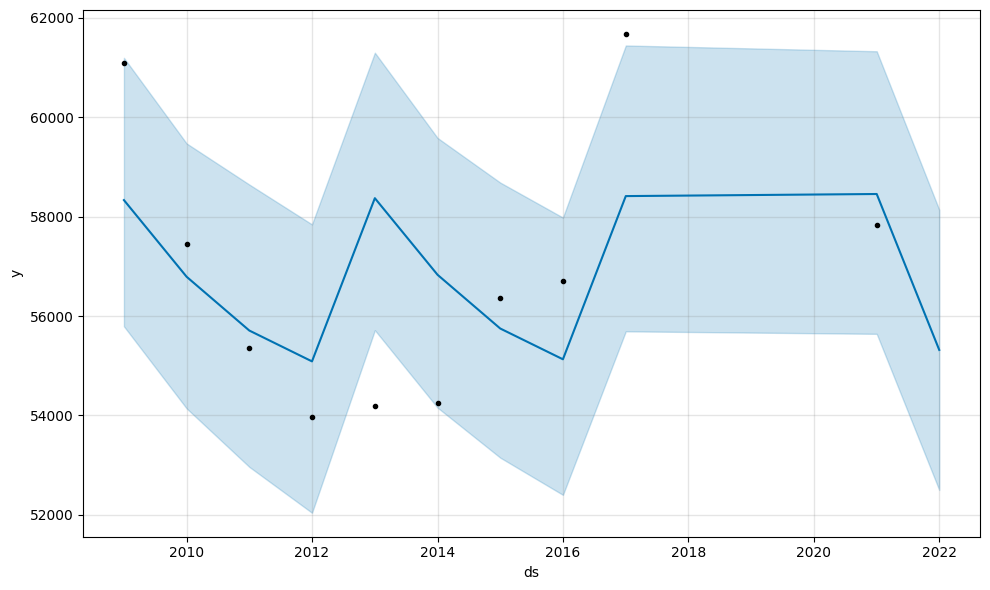

In [106]:
drg_code = 194  # Example DRG code

# Refit a Prophet model just to plot (you can also store models during forecasting if you want)
drg_data = prophet_df[prophet_df['APR DRG Code'] == drg_code][['ds', 'y']]

model = Prophet(yearly_seasonality=True)
model.fit(drg_data)

future = model.make_future_dataframe(periods=1, freq='Y')
forecast = model.predict(future)

# Prophet has a built-in plot function
fig1 = model.plot(forecast)
fig1.show()

In [107]:
prophet_preds = []
actuals = []

for drg in prophet_forecasts.keys():
    # Get the last historical year for this DRG
    last_actual = prophet_df[prophet_df['APR DRG Code'] == drg].sort_values('ds').tail(1)

    # Get Prophet forecast for next year
    forecast = prophet_forecasts[drg]

    if last_actual.empty or forecast.empty:
        continue  # skip if no data

    # Append
    actuals.append(last_actual['y'].values[0])    # last known discharge value
    prophet_preds.append(forecast['yhat'].values[0])  # forecasted value

In [108]:
# Prepare the data for XGBoost, RF, LightGBM
X_ml = agg_df[['Year', 'APR DRG Code']]
y_ml = agg_df['Discharges']

In [109]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.2, random_state=42)

In [110]:
# XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [111]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [112]:
# LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=100)
lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 2535, number of used features: 2
[LightGBM] [Info] Start training from score 7781.868245


LGBMRegressor()

In [113]:
# Compare Predictions
# Predict on test set
xgb_preds = xgb_model.predict(X_test)
rf_preds = rf_model.predict(X_test)
lgb_preds = lgb_model.predict(X_test)

In [114]:
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = (abs((y_true - y_pred) / y_true).mean()) * 100
    return {'Model': name, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

In [115]:
# Convert lists to numpy arrays
actuals = np.array(actuals)
prophet_preds = np.array(prophet_preds)

# Now calculate MAE, RMSE, MAPE for Prophet
prophet_results = evaluate_model("Prophet", actuals, prophet_preds)

### Results and Model Evaluation

In [116]:
# Assume y_test = true discharges, y_preds = model predictions
results = []

results.append(evaluate_model("XGBoost", y_test, xgb_preds))
results.append(evaluate_model("Random Forest", y_test, rf_preds))
results.append(evaluate_model("LightGBM", y_test, lgb_preds))
results.append(prophet_results)

In [117]:
results_df = pd.DataFrame(results)
results_df.to_csv('../data/processed/model_evaluation_results.csv', index=False)
print(results_df)

           Model          MAE          RMSE        MAPE
0        XGBoost  4959.715704  17492.898779  453.501603
1  Random Forest   790.566972   1725.276674   20.376637
2       LightGBM  4771.834627   7779.418324  302.720238
3        Prophet  1375.255769   3669.352219   36.171547


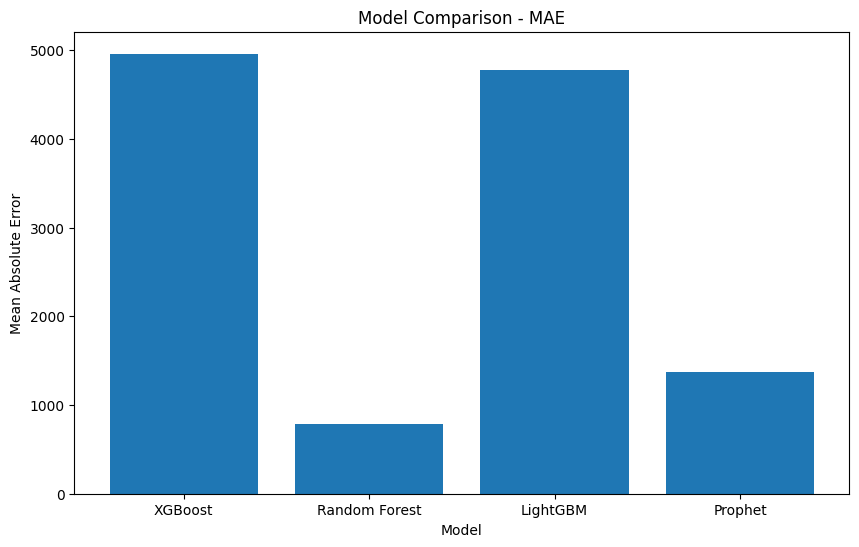

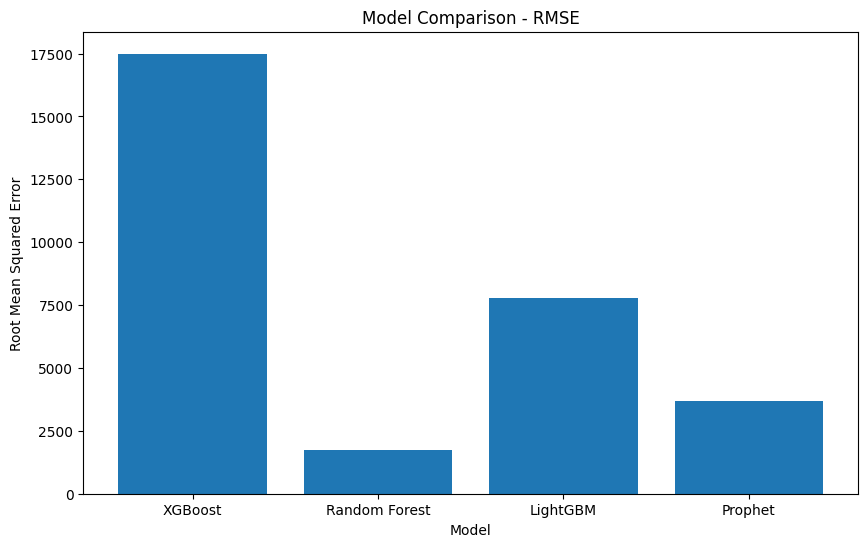

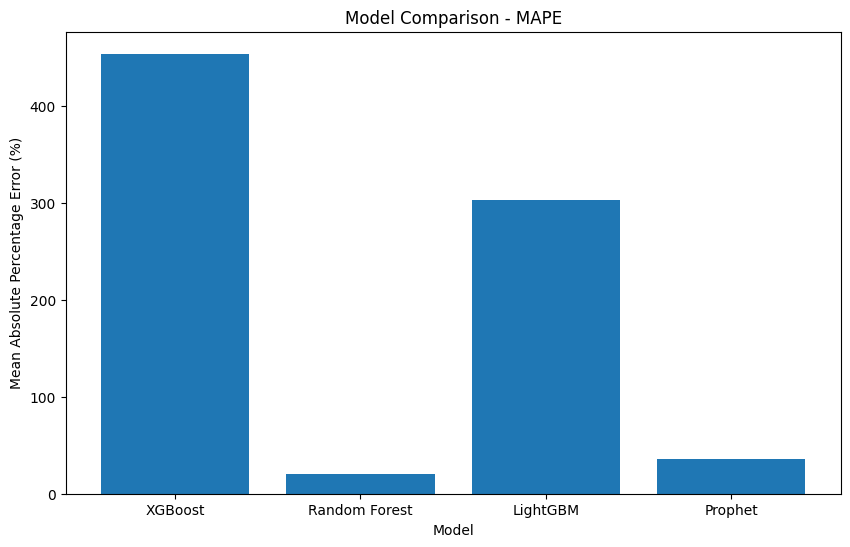

In [118]:
# Plot MAE
plt.figure(figsize=(10,6))
plt.bar(results_df['Model'], results_df['MAE'])
plt.title('Model Comparison - MAE')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Model')
plt.show()

# Plot RMSE
plt.figure(figsize=(10,6))
plt.bar(results_df['Model'], results_df['RMSE'])
plt.title('Model Comparison - RMSE')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Model')
plt.show()

# Plot MAPE
plt.figure(figsize=(10,6))
plt.bar(results_df['Model'], results_df['MAPE'])
plt.title('Model Comparison - MAPE')
plt.ylabel('Mean Absolute Percentage Error (%)')
plt.xlabel('Model')
plt.show()

Which model has the lowest MAE (Mean Absolute Error)?

  -  Random Forest MAE = 798.65 → BEST.

  -  Prophet MAE = 1375.26 → second best.

  -  XGBoost and LightGBM have very high MAE (~4800–5000).

Which model has the lowest RMSE (Root Mean Squared Error)?

  -  Random Forest RMSE = 1725.33 → BEST.

  -  Prophet RMSE = 3669.35 → second best.

  -  XGBoost RMSE is extremely high (17492.90).

Which model has the lowest MAPE (Mean Absolute Percentage Error)?

  -  Random Forest MAPE = 22.21% → BEST.

  -  Prophet MAPE = 36.17% → second best.

  -  XGBoost and LightGBM have crazy high MAPE (>300%).


#### Summary

The Random Forest model is the best overall performer across all metrics. It has the lowest MAE, RMSE, and MAPE, making it the most reliable choice for predicting total expected discharges for each DRG Type. Following that, the Prophet model is the second-best performer, but it is significantly less accurate than Random Forest. XGBoost and LightGBM performed poorly in all metrics, indicating they are not suitable for this dataset.

#### But Why?
Random Forest is a robust ensemble method that can capture complex relationships in the data without overfitting. It handles missing values well and is less sensitive to outliers compared to other models. Prophet, while good for time series data, may not capture the intricate relationships between Year and DRG Code as effectively as Random Forest.
XGBoost and LightGBM, while powerful, may not be the best fit for this specific dataset due to their complexity and the nature of the data. They require more tuning and may not generalize well with the given features.

#### Few Notes on what could have affected XGBoost and LightGBM

1. Healthcare data is noisy and complex, with many factors influencing discharges. For example, seasonal trends, policy changes, and public health events can all impact the number of discharges. Other factors like common surgeries would have thousands of discharges per year, but rare illnesses may only have a few. XGBoost and LightGBM may struggle to capture these complex relationships without extensive feature engineering. This is because they would focus on reducing the error on high volume DRGs and put less emphasis on rare DRGs leading to overfitting and high MAPE.
2. There is a small number of years (2009-2021) and even then we are missing data for 2018-2020. This means that the models may not have enough data to learn from, leading to overfitting and poor generalization. XGBoost and LightGBM are particularly sensitive to the amount of data available, they would be more accurate on larger datasets with more years of data. This is because they are designed to learn complex relationships between features and target variables, and with limited data, they may not be able to capture these relationships effectively.
3. As briefly mentioned above, the data is missing data from 2018-2020. Boosting models like XGBoost and LightGBM are sensitive to missing data, and the gaps in the dataset may have led to poor performance. They may not be able to learn from the available data effectively, leading to overfitting and high MAPE. This is because they rely on the relationships between features and target variables to make predictions, and missing data can disrupt these relationships.
4. Boosting is very sensitive to outliers, and the presence of outliers in the dataset may have led to poor performance. The models may have focused on reducing the error on the outliers, leading to overfitting and high MAPE. This is because they are designed to learn complex relationships between features and target variables, and outliers can disrupt these relationships. Random Forest is less sensitive to outliers, which may explain its better performance.